# Домашнее задание к семинару 06 (HW06)
Тема: деревья решений и ансамбли (bagging / random forest / boosting / stacking) и честный ML-эксперимент.

## Загрузка данных и первичный анализ

In [47]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

In [83]:
df = pd.read_csv('S06-hw-dataset-02.csv')

In [49]:
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
0,1,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,...,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167,1
1,2,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,...,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826,0
2,3,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,...,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517,0
3,4,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,...,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860,0
4,5,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,...,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870,0


In [50]:
df.shape

(18000, 39)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [52]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2,target
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000
mean,9000.500000,-0.418555,0.614251,0.004559,0.059000,0.405086,0.012123,-0.283473,-0.266880,0.255107,...,-0.139825,0.108568,0.007238,0.000904,-0.716862,-0.274520,0.344991,1.517339,2.576221e+01,0.262611
std,5196.296758,2.178005,3.926778,1.000134,5.713672,2.497581,0.987226,2.193891,2.081431,2.225776,...,2.148834,2.234315,0.997861,1.002115,3.913704,2.482890,4.927315,10.630850,5.423748e+01,0.440065
min,1.000000,-10.014698,-15.510323,-4.031762,-23.663256,-12.289308,-3.741536,-9.591425,-8.293319,-13.655742,...,-8.171469,-9.214171,-3.937091,-3.963063,-19.389908,-10.031559,-20.768452,-107.788145,1.895059e-07,0.000000
25%,4500.750000,-1.866134,-2.048192,-0.673127,-3.544964,-1.153000,-0.653090,-1.743214,-1.688121,-1.177480,...,-1.589638,-1.369266,-0.663023,-0.684164,-3.286842,-1.897893,-2.752685,-2.018750,1.226029e+00,0.000000
50%,9000.500000,-0.465100,0.600291,0.003581,0.072826,0.485625,0.018765,-0.251263,-0.302463,0.350739,...,-0.204785,0.158715,0.001912,-0.003157,-0.618472,-0.339901,0.573153,0.318011,6.581865e+00,0.000000
75%,13500.250000,0.966393,3.229850,0.671390,3.689490,2.075739,0.689304,1.195481,1.109589,1.764113,...,1.254595,1.600671,0.677296,0.676558,1.948803,1.314163,3.649794,4.212111,2.576847e+01,1.000000
max,18000.000000,9.589975,15.417329,3.817025,26.815691,10.665184,3.528280,7.794627,8.892834,8.699629,...,9.290667,8.794320,4.341030,3.781380,14.065595,10.639974,20.226291,94.891804,1.103449e+03,1.000000


In [84]:
# Распределение таргета
target_dist = df['target'].value_counts(normalize=True)
print(target_dist)

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


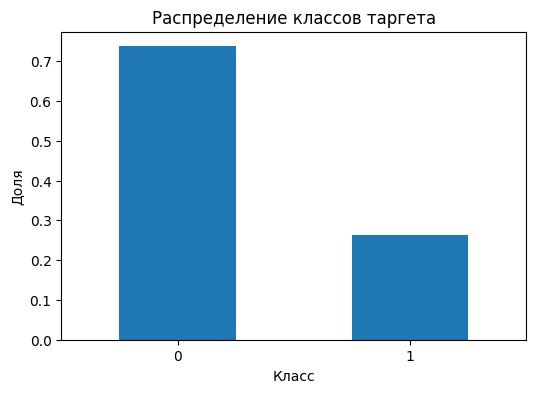

In [54]:
plt.figure(figsize=(6, 4))
target_dist.plot(kind='bar')
plt.title('Распределение классов таргета')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.show()

In [55]:
df.isnull().sum()

id         0
f01        0
f02        0
f03        0
f04        0
f05        0
f06        0
f07        0
f08        0
f09        0
f10        0
f11        0
f12        0
f13        0
f14        0
f15        0
f16        0
f17        0
f18        0
f19        0
f20        0
f21        0
f22        0
f23        0
f24        0
f25        0
f26        0
f27        0
f28        0
f29        0
f30        0
f31        0
f32        0
f33        0
f34        0
f35        0
x_int_1    0
x_int_2    0
target     0
dtype: int64

In [10]:
df.dtypes

id           int64
f01        float64
f02        float64
f03        float64
f04        float64
f05        float64
f06        float64
f07        float64
f08        float64
f09        float64
f10        float64
f11        float64
f12        float64
f13        float64
f14        float64
f15        float64
f16        float64
f17        float64
f18        float64
f19        float64
f20        float64
f21        float64
f22        float64
f23        float64
f24        float64
f25        float64
f26        float64
f27        float64
f28        float64
f29        float64
f30        float64
f31        float64
f32        float64
f33        float64
f34        float64
f35        float64
x_int_1    float64
x_int_2    float64
target       int64
dtype: object

## Train/Test-сплит и воспроизводимость


In [ ]:
RANDOM_STATE = 42

In [85]:
X = df.drop(['target', 'id'], axis=1)
y = df['target']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

In [113]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (13500, 37)
X_test: (4500, 37)
y_train: (13500,)
y_test: (4500,)


In [114]:
print("Распределение таргета в тренировочной выборке")
print(y_train.value_counts(normalize=True))
print("\nРаспределение таргета в тестовой выборке")
print(y_test.value_counts(normalize=True))

Распределение таргета в тренировочной выборке
target
0    0.737407
1    0.262593
Name: proportion, dtype: float64

Распределение таргета в тестовой выборке
target
0    0.737333
1    0.262667
Name: proportion, dtype: float64


**Фиксированный random_state (seed)** обеспечивает воспроизводимость результатов. При одинаковом seed разделение данных будет идентичным при каждом запуске, что позволяет сравнивать разные модели на одинаковых данных и отлаживать код.

**Стратификация (stratify=y)** сохраняет пропорции классов таргета в тренировочной и тестовой выборках такими же, как в исходных данных. Это важно при несбалансированных данных, чтобы избежать ситуации, когда в тестовой выборке окажется слишком мало примеров миноритарного класса, что исказит оценку качества модели.

## Baseline’ы

In [115]:
# - compute_metrics: считает метрики (accuracy, F1, ROC-AUC при наличии вероятностей)
# - evaluate_on_test: единообразная оценка модели на тесте
# - save_json: аккуратное сохранение артефактов
# - plot_confusion / plot_roc: быстрая диагностика качества

def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            m["roc_auc"] = None
    else:
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")

    plt.savefig('artifacts/figures/confusion', dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)

    plt.savefig('artifacts/figures/roc', dpi=300, bbox_inches='tight')
    plt.show()

In [116]:
# Baseline'ы и подготовка контейнеров для результатов.

# - results: список словарей с метриками на тесте
# - best_models: сюда складываем обученные лучшие модели (чтобы потом их диагностировать/сохранить)
# - search_summaries: сюда складываем лучшие параметры подбора и CV-оценку

# CV = кросс-валидация на train: нужна для подбора гиперпараметров без доступа к тесту.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}  # label -> fitted best estimator
search_summaries = {}  # label -> краткая инфа о подборе

In [117]:
# 2.1 Dummy baseline (без подбора)

# Dummy baseline: помогает понять, что модель вообще умеет что-то лучше «угадайки».
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
# Оцениваем на test
y_pred_dum = dummy.predict(X_test)
y_proba_dum = dummy.predict_proba(X_test)[:, 1]

dummy_res = evaluate_on_test(dummy, X_test, y_test, "Dummy(most_frequent)")
results.append(dummy_res)
best_models["Dummy(most_frequent)"] = dummy

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===")
for key in dummy_res: print(f'{key}: {dummy_res[key]}')

=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===
accuracy: 0.7373333333333333
f1: 0.0
roc_auc: 0.5
model: Dummy(most_frequent)


In [118]:
# 2.2 LogisticRegression baseline (с минимальным подбором)

# Логрегрессия почти всегда требует масштабирования признаков, поэтому используем Pipeline со StandardScaler.
lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])


# Подбираем C (обратная сила регуляризации): меньше C -> сильнее регуляризация -> проще модель.
lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"],
}


# GridSearchCV перебирает сетку параметров и оценивает качество по CV. scoring=roc_auc – метрика для бинарной классификации по вероятностям.
lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

LogReg_res = evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)")
results.append(LogReg_res)

search_summaries["LogReg(scaled)"]

print("=== Бейзлайн (LogisticRegression, GridSearchCV) – качество на test ===")
for key in LogReg_res: print(f'{key}: {LogReg_res[key]}')

=== Бейзлайн (LogisticRegression, GridSearchCV) – качество на test ===
accuracy: 0.8155555555555556
f1: 0.5608465608465608
roc_auc: 0.8110480800514855
model: LogReg(scaled)


## Модели недели 6 (обязательно)

In [119]:
# Единая функция для подбора гиперпараметров через GridSearchCV.

# Она:
# - обучает GridSearchCV на X_train/y_train
# - кладёт лучшую модель и summary в словари
# - добавляет финальную оценку на тесте в results

def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True,
        verbose=2
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [120]:
# Decision Tree: одна модель дерева решений.

# Что обычно делает дерево “сложнее” и склоннее к переобучению:
# - большой max_depth
# - маленький min_samples_leaf
# ccp_alpha – параметр cost-complexity pruning (штраф за сложность).

# 3.1 Decision Tree
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_grid = {
    "max_depth": [None, 3, 5, 8],
    "min_samples_leaf": [1, 5, 10, 20],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

dt_search = run_search("DecisionTree", dt, dt_grid)
search_summaries["DecisionTree"]

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'best_params': {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 20},
 'best_cv_roc_auc': 0.8297749605240508}

In [22]:
# Random Forest: ансамбль деревьев (bagging).

# Идеи:
# - много деревьев (n_estimators) снижает дисперсию
# - max_features добавляет разнообразие деревьев (важно для ансамблей)
# - ограничения глубины/листа помогают контролировать переобучение

# 3.2 Random Forest
rf = RandomForestClassifier(
    n_estimators=600,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    oob_score=False
)

rf_grid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", 0.5],
}

rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9274610925469269}

In [121]:
# HistGradientBoosting: градиентный бустинг по гистограммам (быстро и часто качественно).

# Ключевые “ручки”:
# - learning_rate: шаг обучения (меньше -> аккуратнее, часто нужно больше итераций)
# - max_depth / max_leaf_nodes: сложность базовых деревьев
# early_stopping=True включает остановку по внутренней валидации на train.

# 3.3 HistGradientBoosting (быстрый градиентный бустинг в sklearn)
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

hgb_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, None],
    "max_leaf_nodes": [15, 31, 63],
}

hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'best_params': {'learning_rate': 0.05,
  'max_depth': None,
  'max_leaf_nodes': 63},
 'best_cv_roc_auc': 0.9318168712662553}

In [67]:
# Stacking (опционально): ансамбль из нескольких уже обученных моделей + метамодель.

# - estimators: базовые модели (их предсказания идут на вход метамодели)
# - final_estimator: метамодель (здесь логистическая регрессия)
# - cv=5: CV внутри стекинга, чтобы метамодель училась без утечки

estimators = [
    ("lr", best_models["LogReg(scaled)"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"]),
]

stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Стекинг обычно имеет мало “ручек”, поэтому без GridSearch – просто честная оценка
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

{"note": "stacking fitted"}

KeyError: 'RandomForest'

## Метрики качества (обязательно)

In [122]:
# Сводка результатов в таблицу.

# Обратите внимание:
# - ROC-AUC может быть None (если модель не выдаёт вероятности)
# - поэтому для сортировки создаём временный столбец roc_auc_sort

df = pd.DataFrame(results)

# сортировка: roc_auc (если есть) иначе accuracy
df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
3,0.903778,0.799072,0.927289,HistGradientBoosting
2,0.828667,0.659000,0.843611,DecisionTree
1,0.815556,0.560847,0.811048,LogReg(scaled)
0,0.737333,0.000000,0.500000,Dummy(most_frequent)


In [29]:
# Сохранение артефактов эксперимента в artifacts/.

# После выполнения этой ячейки можно открыть папку artifacts/ и увидеть:
# - metrics_test.json (итоговые метрики)
# - search_summaries.json (лучшие параметры подбора)

ARTIFACTS_DIR = Path('artifacts/')

metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [30]:
# Выбор “лучшей” модели по таблице результатов.

# Важно: мы НЕ переобучаем и не меняем модель по тесту.
# Мы только выбираем, какую модель будем диагностировать и сохранять.

best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('Stacking',
 {'accuracy': 0.9164444444444444,
  'f1': 0.831390134529148,
  'roc_auc': 0.9350055942615219,
  'model': 'Stacking'})

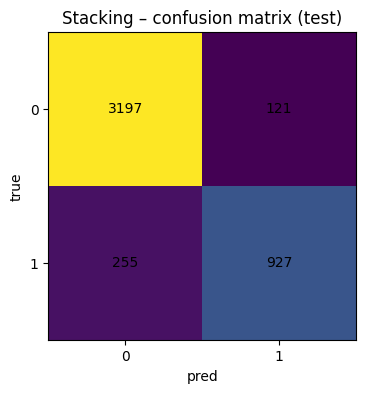

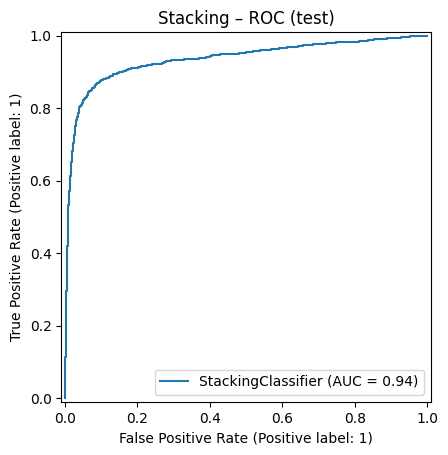

In [36]:
# Диагностика на тесте: confusion matrix и ROC-кривая.

# Confusion matrix помогает понять тип ошибок (FP/FN),
# ROC показывает качество ранжирования вероятностей по всем порогам.

y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

## Интерпретация (обязательно)

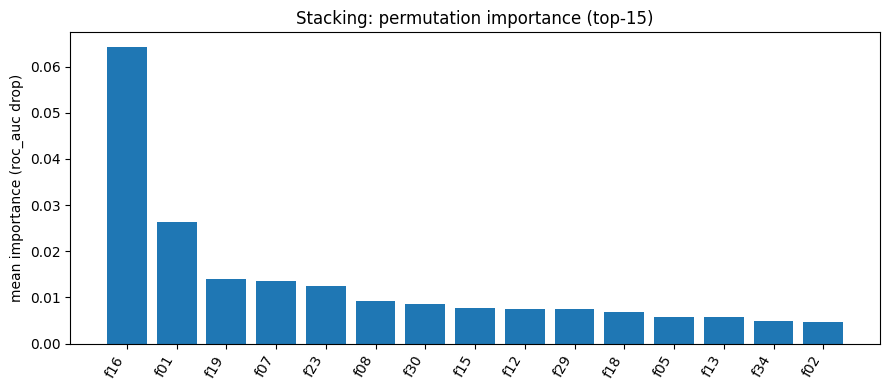

In [42]:
# Permutation importance на тесте (top-15).

# Идея: перемешиваем один признак и смотрим, насколько падает качество.
# Чем больше падение, тем “важнее” признак для модели.
feature_names = X.columns.tolist()
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.show()

Модель устойчива и использует множество признаков:
   - Максимальное падение всего ~0.06 означает, что модель НЕ опирается на один-два ключевых признака.
   - Это признак хорошей, робастной модели — она не "переобучается" на шум в одном признаке.
   
Признаковое пространство распределено равномерно:
   - TOP-15 признаков с importance в диапазоне 0.0-0.07.
   - Не существует одного признака, который бы объяснял всё или почти всё.

In [43]:
# Сохранение лучшей модели и метаданных.

# - best_model.joblib: сериализованная модель
# - best_model_meta.json: “паспорт” результата (какая модель, какие метрики, какие параметры)

model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json
